Train a multilayer perceptron on the MNIST dataset. Compare a “vanilla” model with a model using drop-out. Visualize the learning curves.
[Running model 10pts, model selection 5pts, dropout 5pts, BN 5pts, learning curve 5pts]


In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from keras import backend as K

Using TensorFlow backend.


In [5]:
# load data
from keras.datasets import mnist

In [6]:
def mnist_data_split():
    r"""return processed train and test data,
    the actual process takes place here includes:
    1. reshape to nofrows, 28, 28, 1
    2. shuffle
    3. dummify labels
    """
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # input image dimensions
    img_rows, img_cols = 28, 28
    num_classes = 10
    # the data, shuffled and split between train and test sets
    
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    y_train = y_train.astype('int32')
    y_test = y_test.astype('int32')
    
    print("after process: X train shape: {}, X test shape: {}, y train shape: {}, y test shape: {}".format(x_train.shape, x_test.shape, y_train.shape, y_test.shape))
    return  x_train, x_test, y_train, y_test

In [7]:
x_train, x_test, y_train, y_test = mnist_data_split()

('x_train shape:', (60000, 784))
(60000, 'train samples')
(10000, 'test samples')
after process: X train shape: (60000, 784), X test shape: (10000, 784), y train shape: (60000, 10), y test shape: (10000, 10)


In [8]:
print ("inputshape is : {}".format(x_train.shape[1]))

inputshape is : 784


### the vanila baseline has test accuracy 0.9657

In [11]:
def train_mnist_nnet_baseline( x_train, x_test, y_train, y_test):
    r"""
    Returns
    -------
    hisotry_callback : <class 'keras.callbacks.History'>
        used for retrospective examiniation
    """
    
    num_class = 10
    epochs = 32
    batch_size = 128
    input_shape = (784, ) #(784, )
    model = Sequential()
    model.add(Dense(32, input_shape=input_shape, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(num_class, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=['accuracy'])
    
    history_callback = model.fit(
                  x_train, 
                  y_train, 
                  verbose=0, 
                  batch_size=batch_size,
                  validation_data=(x_test, y_test),
                  epochs=epochs
              )
    
    score = model.evaluate(x_test, y_test, verbose=0)
    
    print("Test loss: {}".format(score[0]))
    print("Test accuracy: {}".format(score[1]))
    #print(model.summary())

    return history_callback

In [12]:
%time callback = train_mnist_nnet_baseline(x_train, x_test, y_train, y_test)

Test loss: 0.135442050519
Test accuracy: 0.9657
CPU times: user 1min 13s, sys: 2.93 s, total: 1min 16s
Wall time: 51.1 s


In [13]:
def plot_history(logger):

    df = pd.DataFrame(logger)
    df[['acc', 'val_acc']].plot()
    plt.ylabel("accuracy")
    plt.ylabel("loss")

### learning curve of the baseline single model

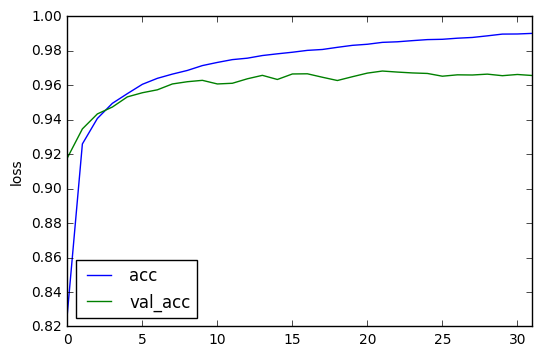

In [14]:
%matplotlib inline
plot_history(callback.history)

### Model selection using grid search (without dropout)

the best combination of parameters for a network without dropout are:  
    1. 64 epoches  
    2. first hidden layer with size 64, second hidden layer with size 32  
    3. with batch size fixed with 128  
achieves 0.971 test score

In [15]:
def make_mnist_nnet(hidden_size=16):
    r"""
    Returns
    -------
    model : model itself
    """
    
    num_class = 10
    input_shape = (784, ) #(784, )
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=input_shape, activation="relu"))
    model.add(Dense(int(hidden_size/2), activation="relu"))
    model.add(Dense(num_class, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=['accuracy'])


    return model

In [16]:
# calculated in by the script on GPU
# clf = KerasClassifier(make_mnist_nnet)
# param_grid = {'epochs': [12, 32, 64], 'hidden_size': [32, 64], 'batch_size':[128]}
# grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
# grid.fit(x_train, y_train.astype('int32'))

In [17]:
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# %matplotlib inline
# res = pd.DataFrame(grid.cv_results_)
# res.pivot_table(index=["param_epochs", "hidden_size"],
#                 values=['mean_train_score', "mean_test_score"])

In [ ]:
# print ("mean test score: {} ".format(grid.cv_results_['mean_test_score']))

In [ ]:
# print ("mean train score: {} ".format(grid.cv_results_['mean_train_score']))

mean test score: [ 0.95998333  0.9682      0.96158333  0.97016667  0.95916667  0.97126667] 


mean train score: [ 0.9782125   0.9906625   0.99300833  0.99909583  0.99725833  0.99918333] 

best params: {'epochs': 64, 'hidden_size': 64, 'batch_size': 128}

### Add drop out; gridsearch learning rate; test accuracy as 0.974 
After grid search of drop out rate, we found that the best score is 0.974 with drop out rate as 0.1, which is 0.8% higher that vanila baseline

In [25]:
# grid search drop out value 
def make_mnist_nnet_dropout(dropout_rate=0.2):
    r"""
    Returns
    -------
    model : model itself
    """
    num_class = 10
    hidden_size = 64
    input_shape = (784, ) #(784, )
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=input_shape, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(int(hidden_size/2), activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_class, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=['accuracy'])


    return model

In [27]:
# clf1 = KerasClassifier(make_mnist_nnet_dropout)
# param_grid1 = {'epochs': [64], 'dropout_rate': [0.1, 0.2, 0.3], 'batch_size':[128]}
# grid1 = GridSearchCV(clf1, param_grid=param_grid1, cv=5)
# grid1.fit(x_train, y_train.astype('int32'))

best params: {'epochs': 64, 'dropout_rate': 0.1, 'batch_size': 128}  
mean test score: [ 0.97425  0.97125  0.9686 ]   
mean train score: [ 0.9992125  0.997375   0.9932625]  

After running on GPU, we find that adding dropout, with rate as 0.1 achieves, 0.974 test accuracy. 

In [28]:
def train_mnist_dropout_nnet( x_train, x_test, y_train, y_test):
    r"""
    Returns
    -------
    hisotry_callback : <class 'keras.callbacks.History'>
        used for retrospective examiniation
    """
    
    num_class = 10
    epochs = 64
    batch_size = 128
    input_shape = (784, ) #(784, )
    model = Sequential()
    model.add(Dense(64, input_shape=input_shape, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(num_class, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=['accuracy'])
    
    history_callback = model.fit(
                  x_train, 
                  y_train, 
                  verbose=0, 
                  batch_size=batch_size,
                  validation_data=(x_test, y_test),
                  epochs=epochs
              )
    
    score = model.evaluate(x_test, y_test, verbose=0)
    
    print("Test loss: {}".format(score[0]))
    print("Test accuracy: {}".format(score[1]))
    #print(model.summary())

    return history_callback

In [29]:
callback1 = train_mnist_dropout_nnet( x_train, x_test, y_train, y_test)

Test loss: 0.114401048315
Test accuracy: 0.975


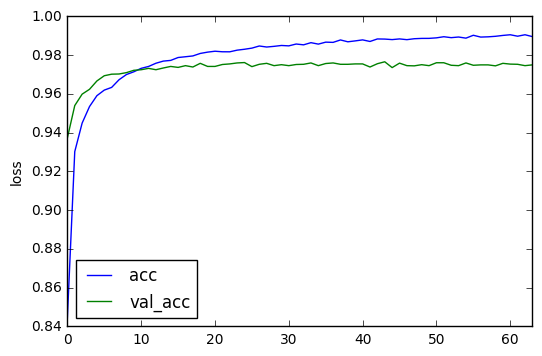

In [30]:
%matplotlib inline
plot_history(callback1.history)

#### adding drop out helps, brings up the accuracy by 0.3% from the best DNN without dropout.

In [31]:
def train_mnist_nnet_advanced( x_train, x_test, y_train, y_test, add_dropout=False, hidden_size=64, epochs=32, dropout_rate=0.1):
    r"""
    Returns
    -------
    hisotry_callback : <class 'keras.callbacks.History'>
        used for retrospective examiniation
    """
    
    num_class = 10
    batch_size = 128
    input_shape = (784, ) #(784, )
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=input_shape, activation="relu"))
    if add_dropout:
        model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_size/2, activation="relu"))
    if add_dropout:
        model.add(Dropout(dropout_rate))
    model.add(Dense(num_class, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=['accuracy'])
    
    history_callback = model.fit(
                  x_train, 
                  y_train, 
                  verbose=0, 
                  batch_size=batch_size,
                  validation_data=(x_test, y_test),
                  epochs=epochs
              )
    
    score = model.evaluate(x_test, y_test, verbose=0)
    
    print("Test loss: {}".format(score[0]))
    print("Test accuracy: {}".format(score[1]))
    #print(model.summary())

    return history_callback

### Learning Curve Comparison

In [33]:
c1 = train_mnist_nnet_advanced(x_train, x_test, y_train, y_test, hidden_size=64, epochs=64 )

Test loss: 0.180601486817
Test accuracy: 0.9734


In [32]:
c2 = train_mnist_nnet_advanced(x_train, x_test, y_train, y_test, add_dropout=True, hidden_size=64, epochs=64 )

Test loss: 0.099832948818
Test accuracy: 0.9795


(0.8, 1)

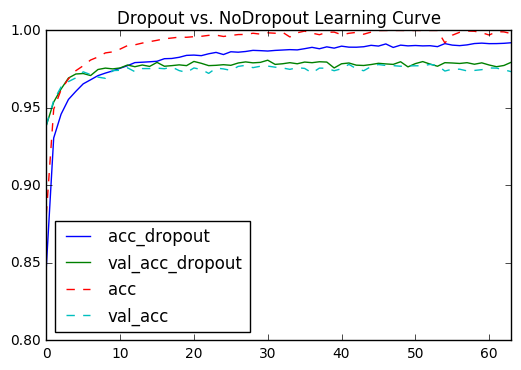

In [39]:
hist_c1 = pd.DataFrame(c1.history)
hist_c2 = pd.DataFrame(c2.history)
hist_c2.rename(columns=lambda x: x + "_dropout", inplace=True)
hist_c2[['acc_dropout', 'val_acc_dropout']].plot()
hist_c1[['acc', 'val_acc']].plot(ax=plt.gca(), linestyle='--')
plt.title("Dropout vs. NoDropout Learning Curve")
plt.ylim(.8, 1)

#### we can see that without dropout the train accuracy is very high, indicating overfitting. With dropout, the test accuracy improves!